In [1]:
# Import every needed library
from typing import List, Dict
%matplotlib inline

import geopandas
import numpy as np
from shapely.geometry import Point, LineString, shape, MultiLineString, Polygon, polygon, MultiPolygon
from shapely.ops import linemerge

In [2]:
# Read all the country shapes data
romania = geopandas.read_file('zip://./data/rou0.zip')
romania1 = geopandas.read_file('zip://./data/rou1.zip')
romania2 = geopandas.read_file('zip://./data/rou2.zip')

hungary = geopandas.read_file('zip://./data/hungary.zip')
serbia = geopandas.read_file('zip://./data/serbia.zip')
bulgaria = geopandas.read_file('zip://./data/bulgaria.zip')
ukraine = geopandas.read_file('zip://./data/ukraine.zip')
moldova = geopandas.read_file('zip://./data/moldova.zip')

<AxesSubplot:>

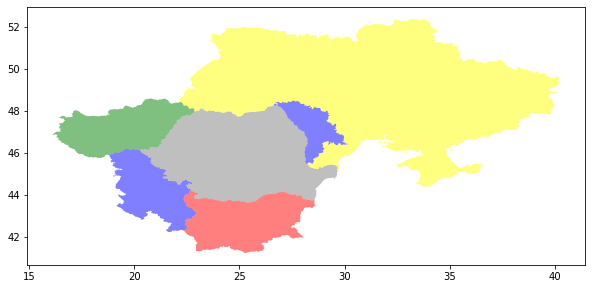

In [3]:
# Make a plot with all the countries to check them
together_maps = geopandas.GeoSeries([romania.geometry.squeeze(), hungary.geometry.squeeze(), serbia.geometry.squeeze(), bulgaria.geometry.squeeze(), ukraine.geometry.squeeze(), moldova.geometry.squeeze()])
together_maps.plot(alpha=0.5, color=['gray', 'green', 'blue', 'red', 'yellow', 'blue'], figsize=(10, 10))

<AxesSubplot:>

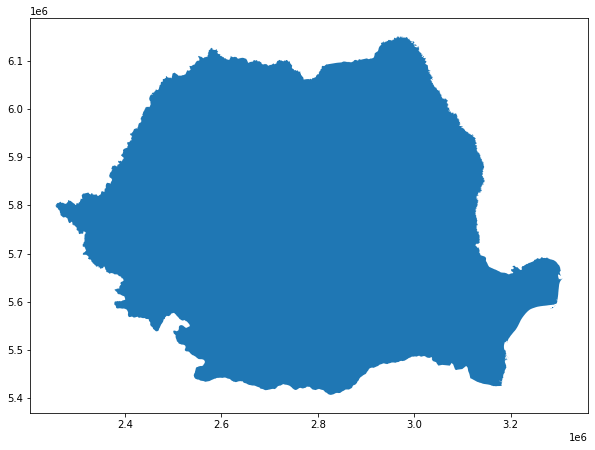

In [4]:
# Take out the geometries of each country
rom_geom = romania.to_crs(epsg=3857).geometry
hun_geom = hungary.to_crs(epsg=3857).geometry
srb_geom = serbia.to_crs(epsg=3857).geometry
blg_geom = bulgaria.to_crs(epsg=3857).geometry
ukr_geom = ukraine.to_crs(epsg=3857).geometry
mld_geom = moldova.to_crs(epsg=3857).geometry
neighbours = [hun_geom.squeeze(), srb_geom.squeeze(), blg_geom.squeeze(), ukr_geom.squeeze(), mld_geom.squeeze()]

# Placing each neighbouring country in a list and a dict
neighbours_geom = [hun_geom, srb_geom, blg_geom, ukr_geom, mld_geom]
neighbours_name = ["hun", "srb", "blg", "ukr", "mld"]
neighbours_points = {name: list() for name in neighbours_name}

# Checking the dimensions of Romania
rom_geom.plot(figsize=(10, 10))

In [5]:
def check_and_add_point(country_geom: geopandas.GeoDataFrame,
                        neighbour_geom: List[geopandas.GeoDataFrame],
                        neighbour_name: List[str],
                        neighbour_points: Dict[str, List[Point]],
                        geo_point: Point
                        ) -> bool:
    """
    Checks if a given geographical point is inside the country_geom (given country geometry) and, if
    that is true, checks if it is equally distant to two other neighbour countries (using neighbour_geom).
    If it is e.d., it is added to neighbours_points and returns True (otherwise False).
    :param country_geom: Geometry of a country
    :param neighbour_geom: List of geometries of other/neighbour countries
    :param neighbour_name: List of names for the neighbor countries (for better computations)
    :param neighbour_points: Dict of lists. Keys -> names from neighbour_name
                                            Values -> list of points which belong to that country
    :param geo_point: Point which is verified (Shapely Point)
    :return: True if the point was an equally distant point and was added to a list
             False otherwise
    """
    # Check if the point is inside the polygon
    if not country_geom.contains(geo_point).bool():
        return False

    dist_list = dict()
    # Compute the distances to each neighbouring country
    for ind, geom in enumerate(neighbour_geom):
        dist_list[neighbour_name[ind]] = float(geom.distance(geo_point))
        
    # Sort the distances
    dist_list = dict(sorted(dist_list.items(), key=lambda item: item[1]))
    dict_iter = iter(dist_list.values())
    first = next(dict_iter)
    second = next(dict_iter)
    third = next(dict_iter)
    
    # If the distance difference is under 500m, then add the point to the neighbours dictionaries
    if second - first <= 500:
        dict_iter = iter(dist_list.keys())
        num = 3 if third - first <= 500 else 2
        for i in range(num):
            iter_key = next(dict_iter)
            neighbour_points[iter_key].append(geo_point)
        return True
    return False

In [6]:
# Parse through the limits of the map and save points which are on the "border" 
# (points which are equally distant to two other countries)

border_points = list()

for x_part in np.arange(2200000, 3200000, 5000):
    for y_part in np.arange(5350000, 6150000, 5000):
        # Create a new point and check it
        new_point = Point((x_part, y_part))
        if check_and_add_point(rom_geom, neighbours_geom, neighbours_name, neighbours_points, new_point):
            border_points.append(new_point)
print(len(border_points))

85


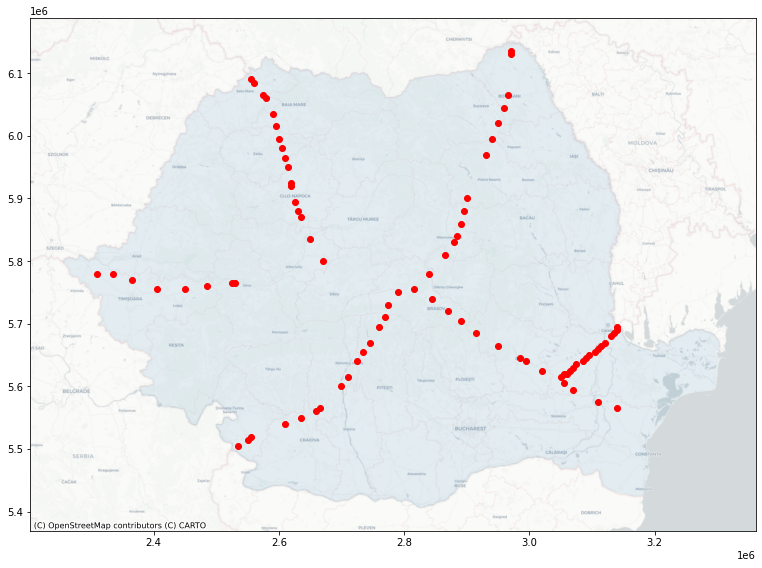

In [7]:
# Check out the map with the found points (which are few)
ax = romania1.to_crs(epsg=3857).geometry.plot(figsize=(13, 13), alpha=0.1)
geopandas.GeoSeries(border_points).plot(ax=ax, color='red')
import contextily
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)
# ax.set_axis_off()

<AxesSubplot:>

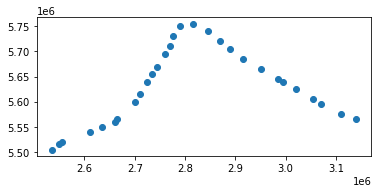

In [8]:
# Check the points for a country (Bulgaria)
geopandas.GeoSeries(neighbours_points['blg']).plot()

532


<AxesSubplot:>

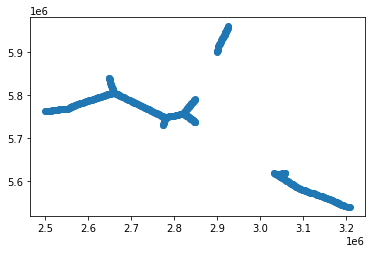

In [9]:
# I need more points near the middle of the map, the Black Sea and Moldova
extra_points = list()
# Add more points near the middle region
for x_part in np.arange(2500000, 2850000, 1000):
    for y_part in np.arange(5730000, 5840000, 1000):
        new_point = Point((x_part, y_part))
        if check_and_add_point(rom_geom, neighbours_geom, neighbours_name, neighbours_points, new_point):
            extra_points.append(new_point)

# Add more points near the Black Sea region
for x_part in np.arange(3000000, 3220000, 1000):
    for y_part in np.arange(5500000, 5620000, 1000):
        new_point = Point((x_part, y_part))
        if check_and_add_point(rom_geom, neighbours_geom, neighbours_name, neighbours_points, new_point):
            extra_points.append(new_point)

# Add more points in Moldova
for x_part in np.arange(2900000, 2970000, 1000):
    for y_part in np.arange(5900000, 5960000, 1000):
        new_point = Point((x_part, y_part))
        if check_and_add_point(rom_geom, neighbours_geom, neighbours_name, neighbours_points, new_point):
            extra_points.append(new_point)


print(len(extra_points))
geopandas.GeoSeries(extra_points).plot()

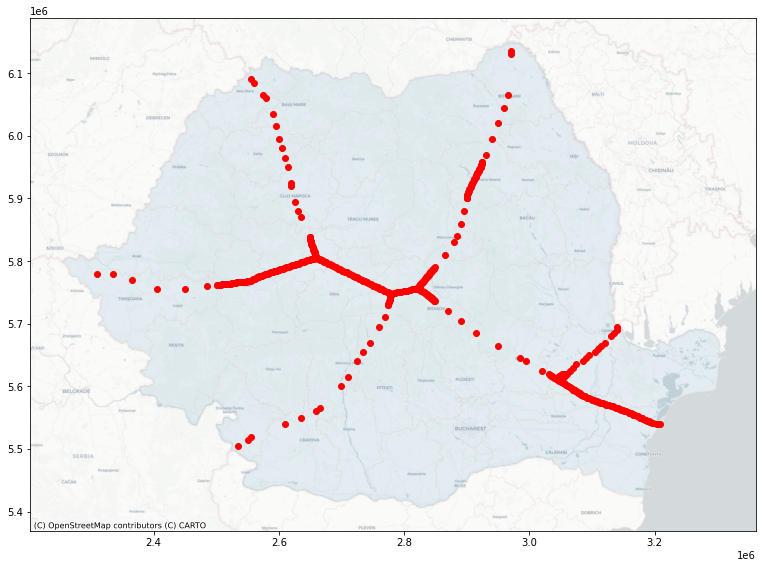

In [10]:
# Check out again the map with the found points
ax = romania1.to_crs(epsg=3857).geometry.plot(figsize=(13, 13), alpha=0.1)
geopandas.GeoSeries(border_points + extra_points).plot(ax=ax, color='red')
import contextily
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)

In [11]:
import math
def clockwiseangle_and_distance(given_point):
    """
    Helper function for sorting points in clockwise order
    :return: The angle in radians and the length of the vector defined by the given point
    """
    point = [given_point.x, given_point.y]
    # Vector between point and the origin: v = p - o
    vector = [point[0] - origin[0], point[1] - origin[1]]
    # Length of vector: ||v||
    vector_len = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if vector_len == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0] / vector_len, vector[1] / vector_len]
    dot_product  = normalized[0] * refvec[0] + normalized[1] * refvec[1]     # x1 * x2 + y1 * y2
    diff_product = refvec[1] * normalized[0] - refvec[0] * normalized[1]     # x1 * y2 - y1 * x2
    angle = math.atan2(diff_product, dot_product)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2 * math.pi + angle, vector_len
    # I return first the angle because that's the primary sorting criteria
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, vector_len

In [12]:
def create_part_polygon(country_border_points: LineString,
                        inner_points: List[Point]
                        ) -> Polygon:
    """
    Uses border points together with equally distant points to create a Polygon
    :param country_border_points: Points along the border of a country
    :param inner_points: List of equally distant points which are closer to the given border
    :return: Polygon object created using the points
    """
    # Create a list of the border points, then extend it with the inner points
    polygon_points = [b_point for b_point in country_border_points.coords]
    polygon_points.extend( reversed(inner_points) )
    # Create the polygon and return it
    return Polygon(polygon_points)

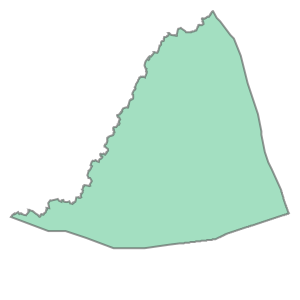

In [13]:
# Now we need to create the parts of each country.
# Get the inner equally distant points together with the border points to create polygons for each state

# Hungary chunk
copy_points = neighbours_points['hun']
origin = [2450000, 5900000]
refvec = [0, 1]

copy_points = sorted(copy_points, key=clockwiseangle_and_distance)
hun_border = hun_geom.intersection(rom_geom)
border_points = linemerge(hun_border[0].geoms)

hun_part = create_part_polygon(border_points, copy_points)
hun_part

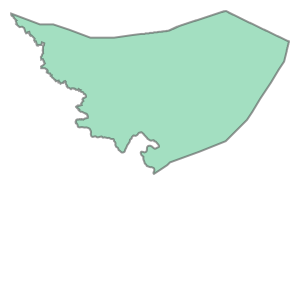

In [14]:
# Serbia chunk
copy_points = neighbours_points['srb']
origin = [2000000, 5500000]

copy_points = sorted(copy_points, key=clockwiseangle_and_distance)
srb_border = srb_geom.intersection(rom_geom)
border_points = list(linemerge(srb_border[0].geoms))[0]

srb_part = create_part_polygon(border_points, copy_points)
srb_part

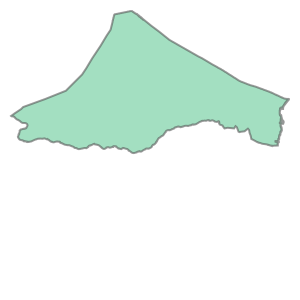

In [15]:
# Bulgaria part
# Extending the line into the Black Sea
copy_points = neighbours_points['blg'] + [Point((3300000, 5500000))]
origin = [3500000, 5000000]

copy_points = sorted(copy_points, key=clockwiseangle_and_distance)
blg_border = blg_geom.intersection(rom_geom)
border_points = list(linemerge(blg_border[0].geoms))[1]

blg_part = create_part_polygon(border_points, copy_points)
# Intersection with the romania geometry results in the coverage of the seaside
blg_part = rom_geom.intersection(blg_part.buffer(0))[0]
blg_part

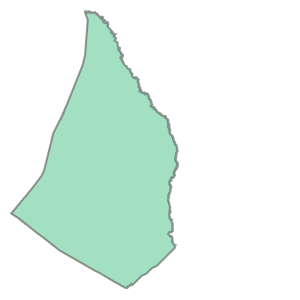

In [16]:
# Moldova points
import random
copy_points = neighbours_points['mld'].copy()
origin = [3000000, 5800000]
        
copy_points = sorted(copy_points, key=clockwiseangle_and_distance)
mld_border = mld_geom.intersection(rom_geom)
border_points = linemerge(mld_border[0].geoms)

mld_part = create_part_polygon(border_points, copy_points)
mld_part

<AxesSubplot:>

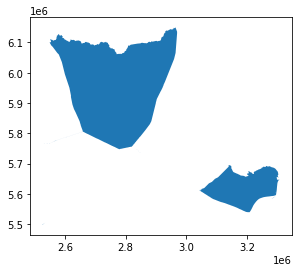

In [17]:
# Ukraine part (the difference multipolygon)
ukr_part = rom_geom.difference(hun_part).difference(srb_part).difference(mld_part).difference(blg_part.buffer(0))
geopandas.GeoSeries(ukr_part).plot()

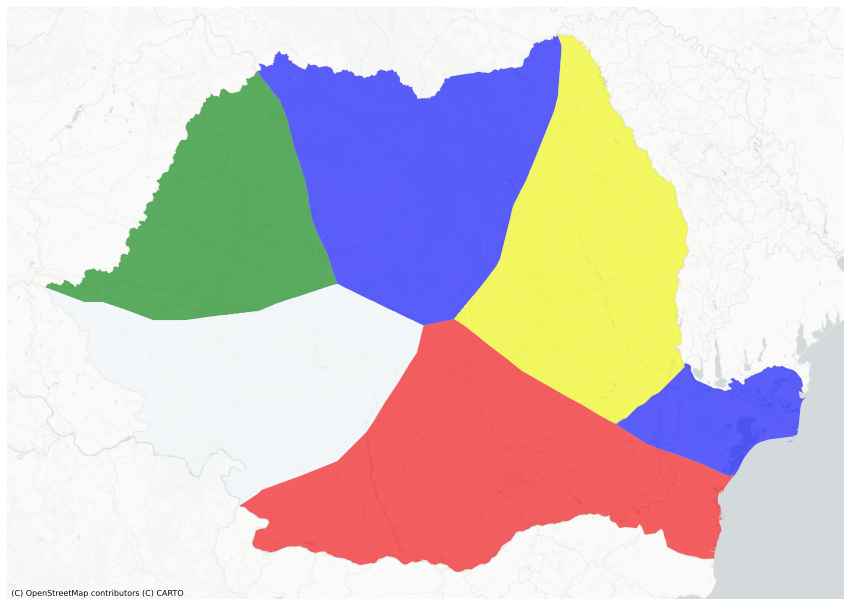

In [18]:
# First try on mapping the pieces
ax = romania1.to_crs(epsg=3857).geometry.plot(figsize=(15, 15), alpha=0.1)
geopandas.GeoSeries([hun_part, srb_part, blg_part, ukr_part[0], mld_part]).plot(ax=ax, color=['green', 'white', 'red', 'blue', 'yellow'], alpha=0.6)
import contextily
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels)
ax.set_axis_off()

In [19]:
# Extend each part with counties
hun_part_extended = romania1.to_crs(epsg=3857).intersection(hun_part)
srb_part_extended = romania1.to_crs(epsg=3857).intersection(srb_part)
blg_part_extended = romania1.to_crs(epsg=3857).intersection(blg_part)
# ukr_part_extended = ukr_part.intersection(romania1.to_crs(epsg=3857))
mld_part_extended = romania1.to_crs(epsg=3857).intersection(mld_part)

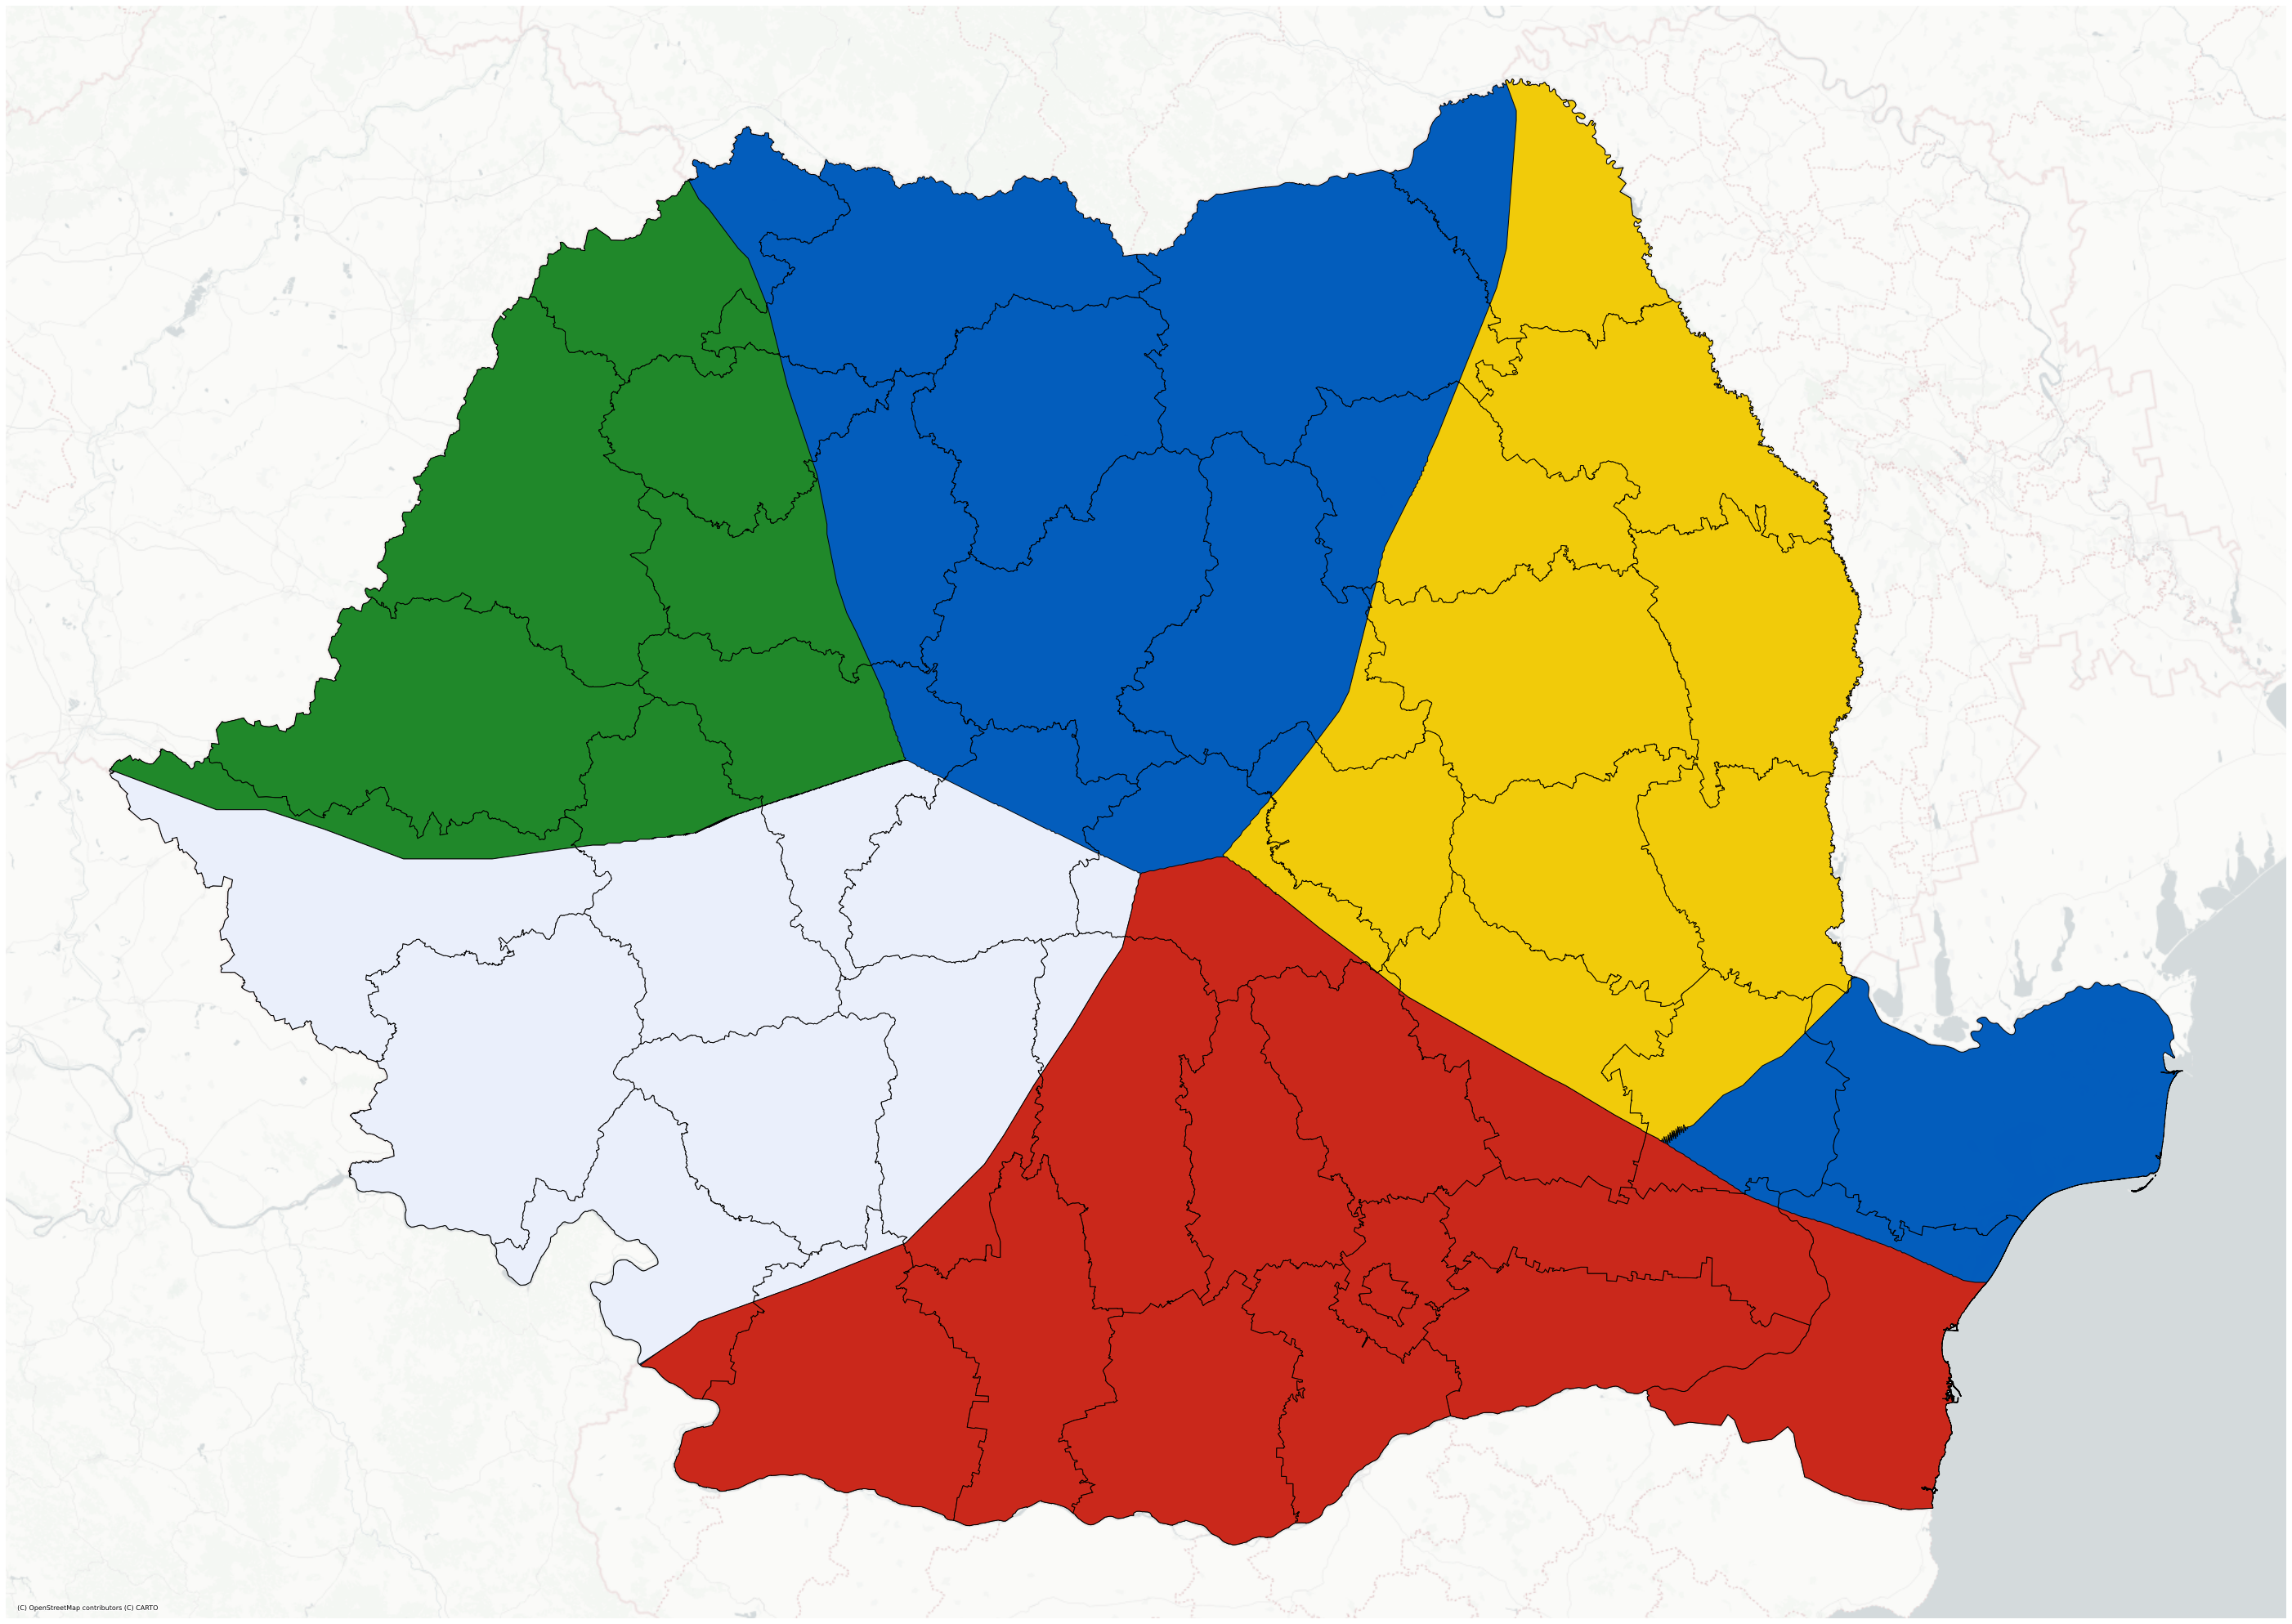

In [22]:
# Second try on mapping the pieces (looks better)
ax = romania1.to_crs(epsg=3857).geometry.plot(figsize=(50, 50), color='#005bbc', alpha=0.99, edgecolor='black')
ax = geopandas.GeoSeries(hun_part_extended).plot(ax=ax, alpha=0.95, edgecolor='black', color='forestgreen')
ax = geopandas.GeoSeries(srb_part_extended).plot(ax=ax, alpha=0.95, edgecolor='black', color='ghostwhite')
ax = geopandas.GeoSeries(blg_part_extended).plot(ax=ax, alpha=0.95, edgecolor='black', color='#d62612')
geopandas.GeoSeries(mld_part_extended).plot(ax=ax, alpha=0.95, edgecolor='black', color='#FFD200')
import contextily
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels)
ax.set_axis_off()
import matplotlib.pyplot as plt
plt.savefig('romania_coloured.jpg')